# Paso 3: Entrenamiento y Evaluación de Modelos

Este notebook implementa el **Paso 3 del Pipeline MLOps**, donde se:
1. Cargan los datos transformados del paso anterior (Feature Engineering)
2. Entrenan múltiples modelos supervisados
3. Evalúan los modelos con métricas de clasificación
4. Seleccionan el mejor modelo basado en performance
5. Guardan el modelo y resultados

## Checklist de Requisitos

- [x] Se entrenan múltiples modelos supervisados (RandomForest, XGBoost, LogisticRegression, SVM, KNN, DecisionTree)
- [x] Se utiliza una función `build_model()` para estructurar el entrenamiento repetible
- [x] Se aplican técnicas de validación (train/test split)
- [x] Se guarda el objeto del modelo seleccionado
- [x] Se utiliza la función `summarize_classification()` para resumir métricas
- [x] Se comparan modelos con métricas: accuracy, precision, recall, F1-score, ROC-AUC
- [x] Se presentan gráficos comparativos (matriz de confusión, gráficos de barras)
- [x] Se justifica la selección del modelo final

---

# Entrenamiento de modelos
Notebook para entrenar y comparar modelos.

## 1. Importar Librerías Necesarias

In [1]:
# Importaciones de análisis y visualización
import pandas as pd
import numpy as np
import json
import joblib
import time
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Importaciones de sklearn - Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Importaciones de sklearn - Métricas
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    roc_auc_score, 
    confusion_matrix, 
    classification_report,
    roc_curve,
    auc
)

# Configuración de rutas
project_root = Path.cwd().parent.parent
data_dir = project_root / "data" / "processed"
artifacts_dir = project_root / "artifacts"

print("✓ Todas las librerías importadas exitosamente")
print(f"✓ Ruta del proyecto: {project_root}")

✓ Todas las librerías importadas exitosamente
✓ Ruta del proyecto: c:\Users\jsanc\OneDrive\Documentos\U\ML\final-project-ml\mlops_pipeline


## 2. Cargar Datos Procesados del Paso Anterior

In [2]:
def load_processed_data():
    """
    Carga los datasets procesados del paso anterior (Feature Engineering).
    
    Returns:
        tuple: (X_train, X_test, y_train, y_test)
    
    Raises:
        FileNotFoundError: Si faltan archivos de datos procesados
    """
    print("="*80)
    print("CARGANDO DATOS PROCESADOS")
    print("="*80)
    
    # Definir archivos requeridos
    required_files = {
        'X_train': data_dir / "X_train.csv",
        'X_test': data_dir / "X_test.csv",
        'y_train': data_dir / "y_train.csv",
        'y_test': data_dir / "y_test.csv"
    }
    
    # Verificar que existan todos los archivos
    missing_files = [name for name, path in required_files.items() if not path.exists()]
    if missing_files:
        raise FileNotFoundError(
            f"❌ Faltan archivos de datos procesados: {missing_files}\n"
            "Por favor, ejecuta primero ft_engineering.py o el notebook correspondiente"
        )
    
    # Cargar datos
    print("\n📂 Cargando archivos CSV...")
    X_train = pd.read_csv(required_files['X_train'])
    X_test = pd.read_csv(required_files['X_test'])
    y_train = pd.read_csv(required_files['y_train'])['Diagnosis']
    y_test = pd.read_csv(required_files['y_test'])['Diagnosis']
    
    print(f"\n✓ Datos cargados exitosamente:")
    print(f"   X_train: {X_train.shape} - Características de entrenamiento")
    print(f"   X_test: {X_test.shape}  - Características de evaluación")
    print(f"   y_train: {y_train.shape} - Etiquetas de entrenamiento")
    print(f"   y_test: {y_test.shape}  - Etiquetas de evaluación")
    
    # Mostrar distribución de clases
    print(f"\n📊 Distribución de clases en y_train:")
    print(y_train.value_counts().sort_index())
    print(f"\n📊 Distribución de clases en y_test:")
    print(y_test.value_counts().sort_index())
    
    return X_train, X_test, y_train, y_test

# Ejecutar la carga de datos
X_train, X_test, y_train, y_test = load_processed_data()

CARGANDO DATOS PROCESADOS

📂 Cargando archivos CSV...

✓ Datos cargados exitosamente:
   X_train: (1719, 32) - Características de entrenamiento
   X_test: (430, 32)  - Características de evaluación
   y_train: (1719,) - Etiquetas de entrenamiento
   y_test: (430,)  - Etiquetas de evaluación

📊 Distribución de clases en y_train:
0    1111
1     608
Name: Diagnosis, dtype: int64

📊 Distribución de clases en y_test:
0    278
1    152
Name: Diagnosis, dtype: int64


## 3. Definir Múltiples Modelos Supervisados

Se entrenarán 6 algoritmos diferentes para comparar performance:

| Modelo | Tipo | Ventajas |
|--------|------|----------|
| Logistic Regression | Lineal | Rápido, interpretable |
| Random Forest | Ensemble | Robusto, maneja no-linealidades |
| Gradient Boosting | Ensemble | Alta performance, previene overfitting |
| Decision Tree | Árbol | Interpretable, rápido |
| KNN | Instancia | Flexible, sin suposiciones |
| SVM | Kernel | Bueno en altas dimensiones |

In [3]:
def build_model(model_name):
    """
    Construye y retorna un modelo supervisado específico.
    Esta función permite reutilizar el entrenamiento de forma estructurada.
    
    Args:
        model_name (str): Nombre del modelo a construir
    
    Returns:
        Modelo de sklearn configurado
    
    Raises:
        ValueError: Si el nombre del modelo no es válido
    """
    models_config = {
        'Logistic Regression': LogisticRegression(
            max_iter=1000,
            random_state=42,
            n_jobs=-1
        ),
        'Random Forest': RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            random_state=42,
            n_jobs=-1
        ),
        'Gradient Boosting': GradientBoostingClassifier(
            n_estimators=100,
            max_depth=5,
            random_state=42
        ),
        'Decision Tree': DecisionTreeClassifier(
            max_depth=10,
            random_state=42
        ),
        'KNN': KNeighborsClassifier(
            n_neighbors=5,
            n_jobs=-1
        ),
        'SVM': SVC(
            kernel='rbf',
            probability=True,
            random_state=42
        )
    }
    
    if model_name not in models_config:
        raise ValueError(f"Modelo {model_name} no disponible. Opciones: {list(models_config.keys())}")
    
    return models_config[model_name]

# Obtener lista de modelos a entrenar
def get_models_to_train():
    """
    Define los modelos a entrenar y evaluar.
    Retorna un diccionario con instancias de cada modelo.
    
    Returns:
        dict: {nombre_modelo: instancia_modelo}
    """
    model_names = [
        'Logistic Regression',
        'Random Forest',
        'Gradient Boosting',
        'Decision Tree',
        'KNN',
        'SVM'
    ]
    
    models = {}
    for model_name in model_names:
        models[model_name] = build_model(model_name)
    
    return models

# Inicializar modelos
models = get_models_to_train()

print("="*80)
print("MODELOS CONFIGURADOS")
print("="*80)
print(f"\n📚 Total de modelos a entrenar: {len(models)}")
for i, model_name in enumerate(models.keys(), 1):
    print(f"   {i}. {model_name}: {type(models[model_name]).__name__}")

MODELOS CONFIGURADOS

📚 Total de modelos a entrenar: 6
   1. Logistic Regression: LogisticRegression
   2. Random Forest: RandomForestClassifier
   3. Gradient Boosting: GradientBoostingClassifier
   4. Decision Tree: DecisionTreeClassifier
   5. KNN: KNeighborsClassifier
   6. SVM: SVC


## 4. Función para Resumir Métricas de Clasificación

Se implementa la función `summarize_classification()` para obtener un resumen completo de performance.

In [4]:
def summarize_classification(model, X_train, X_test, y_train, y_test, model_name=""):
    """
    Función para resumir y retornar todas las métricas de un modelo de clasificación.
    
    Args:
        model: Modelo entrenado
        X_train: Features de entrenamiento
        X_test: Features de prueba
        y_train: Etiquetas de entrenamiento
        y_test: Etiquetas de prueba
        model_name: Nombre del modelo (para reportes)
    
    Returns:
        dict: Diccionario con todas las métricas y predicciones
    """
    # Predicciones en ambos conjuntos
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Obtener probabilidades si es posible
    try:
        y_test_proba = model.predict_proba(X_test)
        if y_test_proba.shape[1] == 2:  # Clasificación binaria
            y_test_proba = y_test_proba[:, 1]
        else:
            y_test_proba = None
    except AttributeError:
        y_test_proba = None
    
    # Métricas de entrenamiento
    train_accuracy = accuracy_score(y_train, y_train_pred)
    
    # Métricas de evaluación/prueba
    test_accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_test_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)
    
    # ROC-AUC (para clasificación binaria)
    try:
        if y_test_proba is not None and len(np.unique(y_test)) == 2:
            roc_auc = roc_auc_score(y_test, y_test_proba)
        else:
            roc_auc = None
    except:
        roc_auc = None
    
    # Calcular overfitting (diferencia entre train y test accuracy)
    overfitting = train_accuracy - test_accuracy
    
    # Matriz de confusión
    cm = confusion_matrix(y_test, y_test_pred)
    
    # Reporte de clasificación
    clf_report = classification_report(y_test, y_test_pred, output_dict=True, zero_division=0)
    
    # Resumen completo
    summary = {
        'model_name': model_name,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'overfitting': overfitting,
        'confusion_matrix': cm,
        'classification_report': clf_report,
        'y_pred': y_test_pred,
        'y_proba': y_test_proba
    }
    
    return summary

print("✓ Función summarize_classification() definida correctamente")

✓ Función summarize_classification() definida correctamente


## 5. Entrenar y Evaluar Todos los Modelos

Se entrena cada modelo con los datos de entrenamiento y se evalúa con los datos de prueba.

In [5]:
def train_and_evaluate_models(models, X_train, X_test, y_train, y_test):
    """
    Entrena y evalúa todos los modelos.
    
    Args:
        models: Diccionario de modelos a entrenar
        X_train, X_test: Features de entrenamiento y prueba
        y_train, y_test: Etiquetas de entrenamiento y prueba
    
    Returns:
        tuple: (results_df, trained_models, all_summaries)
    """
    print("\n" + "="*80)
    print("ENTRENAMIENTO Y EVALUACIÓN DE MODELOS")
    print("="*80)
    
    results = []
    trained_models = {}
    all_summaries = {}
    
    for model_name, model in models.items():
        print(f"\n📚 Entrenando: {model_name}...")
        
        # Medir tiempo de entrenamiento
        start_time = time.time()
        model.fit(X_train, y_train)
        training_time = time.time() - start_time
        
        print(f"   ✓ Entrenamiento completado en {training_time:.2f} segundos")
        
        # Evaluar modelo
        print(f"   📊 Evaluando modelo...")
        summary = summarize_classification(
            model, X_train, X_test, y_train, y_test, model_name
        )
        
        # Guardar resumen
        all_summaries[model_name] = summary
        trained_models[model_name] = model
        
        # Crear fila de resultados
        result = {
            'Modelo': model_name,
            'Train Accuracy': round(summary['train_accuracy'], 4),
            'Test Accuracy': round(summary['test_accuracy'], 4),
            'Precision': round(summary['precision'], 4),
            'Recall': round(summary['recall'], 4),
            'F1-Score': round(summary['f1_score'], 4),
            'ROC-AUC': round(summary['roc_auc'], 4) if summary['roc_auc'] else None,
            'Overfitting': round(summary['overfitting'], 4),
            'Training Time (s)': round(training_time, 2)
        }
        
        results.append(result)
        
        print(f"   ✓ Test Accuracy: {result['Test Accuracy']:.4f}")
        print(f"   ✓ F1-Score: {result['F1-Score']:.4f}")
        if result['ROC-AUC']:
            print(f"   ✓ ROC-AUC: {result['ROC-AUC']:.4f}")
    
    # Crear DataFrame con resultados
    results_df = pd.DataFrame(results)
    
    return results_df, trained_models, all_summaries

# Ejecutar entrenamiento y evaluación
results_df, trained_models, all_summaries = train_and_evaluate_models(
    models, X_train, X_test, y_train, y_test
)

print("\n" + "="*80)


ENTRENAMIENTO Y EVALUACIÓN DE MODELOS

📚 Entrenando: Logistic Regression...
   ✓ Entrenamiento completado en 3.03 segundos
   📊 Evaluando modelo...
   ✓ Test Accuracy: 0.8163
   ✓ F1-Score: 0.8161
   ✓ ROC-AUC: 0.8854

📚 Entrenando: Random Forest...
   ✓ Entrenamiento completado en 0.33 segundos
   📊 Evaluando modelo...
   ✓ Test Accuracy: 0.9488
   ✓ F1-Score: 0.9486
   ✓ ROC-AUC: 0.9402

📚 Entrenando: Gradient Boosting...
   ✓ Entrenamiento completado en 3.25 segundos
   📊 Evaluando modelo...
   ✓ Test Accuracy: 0.9465
   ✓ F1-Score: 0.9465
   ✓ ROC-AUC: 0.9518

📚 Entrenando: Decision Tree...
   ✓ Entrenamiento completado en 0.03 segundos
   📊 Evaluando modelo...
   ✓ Test Accuracy: 0.9000
   ✓ F1-Score: 0.8999
   ✓ ROC-AUC: 0.8770

📚 Entrenando: KNN...
   ✓ Entrenamiento completado en 0.00 segundos
   📊 Evaluando modelo...
   ✓ Test Accuracy: 0.7070
   ✓ F1-Score: 0.6883
   ✓ ROC-AUC: 0.7377

📚 Entrenando: SVM...
   ✓ Entrenamiento completado en 0.55 segundos
   📊 Evaluando modelo.

## 6. Comparación de Modelos - Tabla de Resultados

Resumen de todas las métricas para comparar performance.

In [6]:
# Mostrar tabla de resultados con formato
print("📊 RESULTADOS DE TODOS LOS MODELOS")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)

# Análisis estadístico
print("\n📈 ESTADÍSTICAS POR MÉTRICA:")
print("\nAccuracy en Test:")
print(f"   Media: {results_df['Test Accuracy'].mean():.4f}")
print(f"   Desv. Est.: {results_df['Test Accuracy'].std():.4f}")
print(f"   Mejor: {results_df['Test Accuracy'].max():.4f}")
print(f"   Peor: {results_df['Test Accuracy'].min():.4f}")

print("\nF1-Score:")
print(f"   Media: {results_df['F1-Score'].mean():.4f}")
print(f"   Desv. Est.: {results_df['F1-Score'].std():.4f}")
print(f"   Mejor: {results_df['F1-Score'].max():.4f}")
print(f"   Peor: {results_df['F1-Score'].min():.4f}")

print("\nOverfitting (Train-Test Accuracy):")
print(f"   Media: {results_df['Overfitting'].mean():.4f}")
print(f"   Máximo: {results_df['Overfitting'].max():.4f}")
print(f"   Mínimo: {results_df['Overfitting'].min():.4f}")

📊 RESULTADOS DE TODOS LOS MODELOS
             Modelo  Train Accuracy  Test Accuracy  Precision  Recall  F1-Score  ROC-AUC  Overfitting  Training Time (s)
Logistic Regression          0.8511         0.8163     0.8160  0.8163    0.8161   0.8854       0.0348               3.03
      Random Forest          0.9878         0.9488     0.9488  0.9488    0.9486   0.9402       0.0389               0.33
  Gradient Boosting          0.9994         0.9465     0.9464  0.9465    0.9465   0.9518       0.0529               3.25
      Decision Tree          0.9895         0.9000     0.8999  0.9000    0.8999   0.8770       0.0895               0.03
                KNN          0.8214         0.7070     0.6949  0.7070    0.6883   0.7377       0.1144               0.00
                SVM          0.9412         0.8349     0.8329  0.8349    0.8331   0.8963       0.1064               0.55

📈 ESTADÍSTICAS POR MÉTRICA:

Accuracy en Test:
   Media: 0.8589
   Desv. Est.: 0.0926
   Mejor: 0.9488
   Peor: 0.7070

## 7. Gráficos Comparativos de Modelos

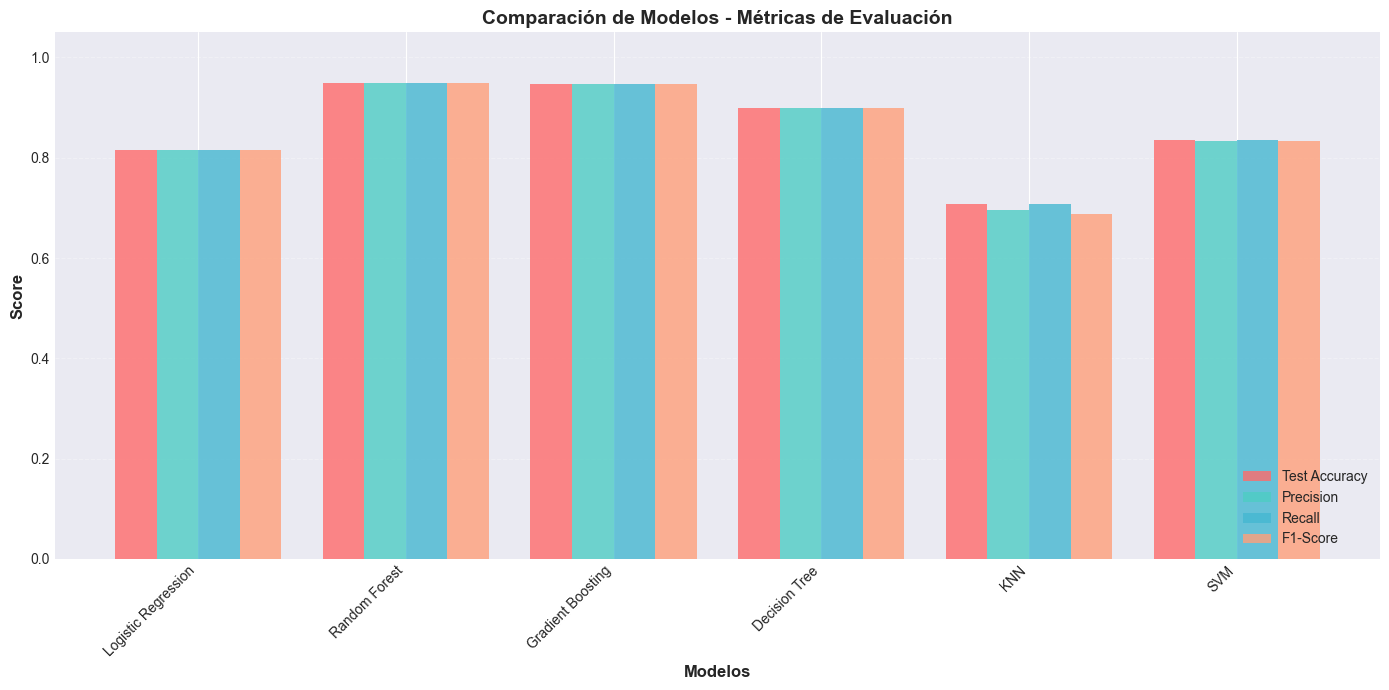

✓ Gráfico comparativo guardado


In [7]:
### 7.1 Gráfico de Barras - Comparación de Métricas

fig, ax = plt.subplots(figsize=(14, 7))

# Preparar datos
metrics_to_plot = ['Test Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(results_df))
width = 0.2

# Crear barras para cada métrica
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
for i, metric in enumerate(metrics_to_plot):
    offset = width * (i - len(metrics_to_plot)/2 + 0.5)
    ax.bar(x + offset, results_df[metric], width, label=metric, color=colors[i], alpha=0.8)

# Personalización
ax.set_xlabel('Modelos', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Comparación de Modelos - Métricas de Evaluación', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(results_df['Modelo'], rotation=45, ha='right')
ax.legend(loc='lower right', fontsize=10)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim([0, 1.05])

plt.tight_layout()
plt.savefig(str(artifacts_dir / "model_comparison.png"), dpi=300, bbox_inches='tight')
plt.show()

print("✓ Gráfico comparativo guardado")

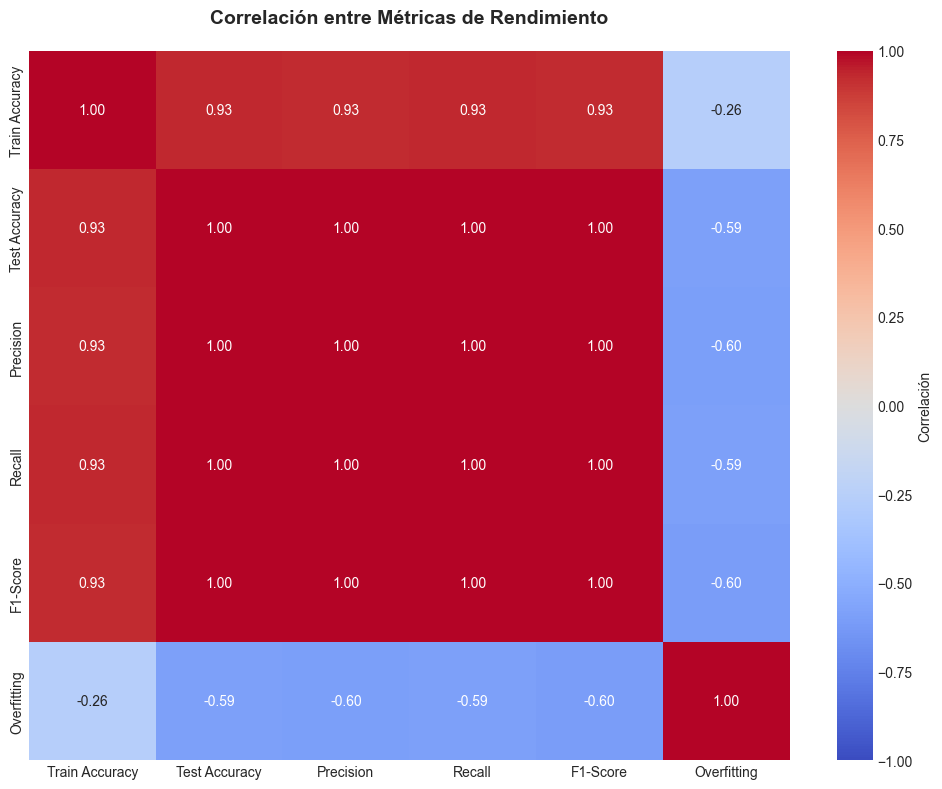

✓ Matriz de correlación guardada


In [8]:
### 7.2 Gráfico de Matriz de Correlación entre Métricas

# Seleccionar columnas numéricas relevantes
metrics_cols = ['Train Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1-Score', 'Overfitting']
correlation_matrix = results_df[metrics_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            cbar_kws={'label': 'Correlación'}, ax=ax, vmin=-1, vmax=1)
ax.set_title('Correlación entre Métricas de Rendimiento', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(str(artifacts_dir / "metrics_correlation.png"), dpi=300, bbox_inches='tight')
plt.show()

print("✓ Matriz de correlación guardada")

C:\Users\jsanc\AppData\Local\Temp\ipykernel_21408\974099447.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(results_df['Modelo'], rotation=45, ha='right')
C:\Users\jsanc\AppData\Local\Temp\ipykernel_21408\974099447.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(results_df['Modelo'], rotation=45, ha='right')


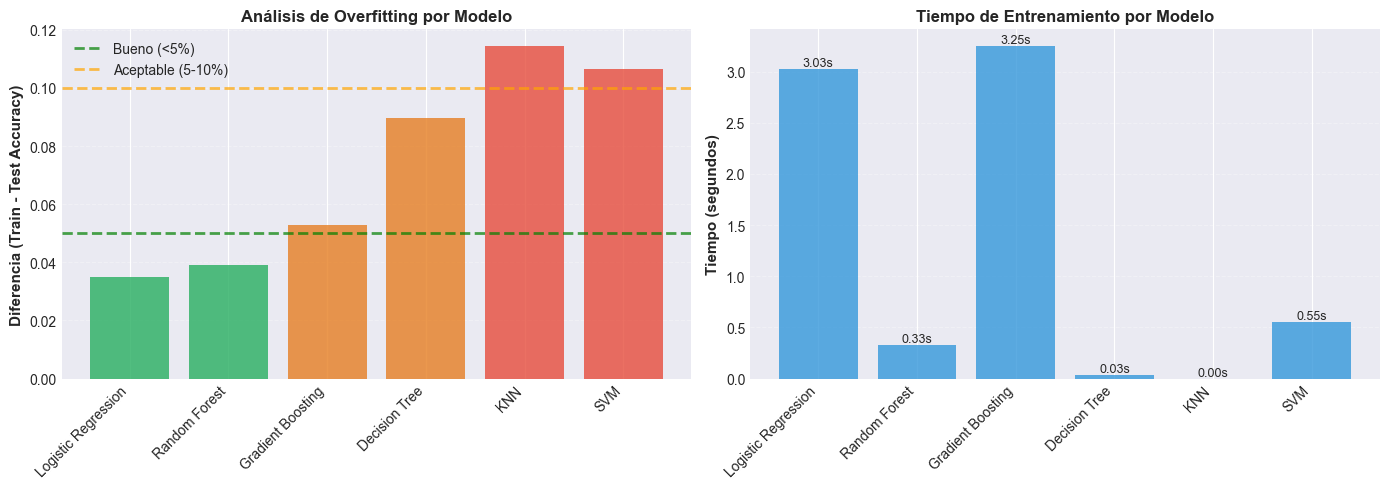

✓ Análisis de overfitting y tiempo guardado


In [9]:
### 7.3 Análisis de Overfitting y Tiempo de Entrenamiento

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Overfitting
ax1 = axes[0]
colors_overfit = ['#27AE60' if x < 0.05 else '#E67E22' if x < 0.1 else '#E74C3C' 
                  for x in results_df['Overfitting']]
bars1 = ax1.bar(results_df['Modelo'], results_df['Overfitting'], color=colors_overfit, alpha=0.8)
ax1.axhline(y=0.05, color='green', linestyle='--', linewidth=2, label='Bueno (<5%)', alpha=0.7)
ax1.axhline(y=0.1, color='orange', linestyle='--', linewidth=2, label='Aceptable (5-10%)', alpha=0.7)
ax1.set_ylabel('Diferencia (Train - Test Accuracy)', fontsize=11, fontweight='bold')
ax1.set_title('Análisis de Overfitting por Modelo', fontsize=12, fontweight='bold')
ax1.set_xticklabels(results_df['Modelo'], rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# Gráfico 2: Tiempo de entrenamiento
ax2 = axes[1]
bars2 = ax2.bar(results_df['Modelo'], results_df['Training Time (s)'], color='#3498DB', alpha=0.8)
ax2.set_ylabel('Tiempo (segundos)', fontsize=11, fontweight='bold')
ax2.set_title('Tiempo de Entrenamiento por Modelo', fontsize=12, fontweight='bold')
ax2.set_xticklabels(results_df['Modelo'], rotation=45, ha='right')
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# Agregar valores en las barras
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}s', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(str(artifacts_dir / "overfitting_time_analysis.png"), dpi=300, bbox_inches='tight')
plt.show()

print("✓ Análisis de overfitting y tiempo guardado")

## 8. Selección del Mejor Modelo

Se selecciona el modelo óptimo basado en un sistema de criterios jerárquicos:
1. **F1-Score**: Métrica principal (balance precision-recall)
2. **Test Accuracy**: Métrica secundaria
3. **Overfitting**: Preferir modelos con menor brecha train-test

In [10]:
def select_best_model(results_df, trained_models):
    """
    Selecciona el mejor modelo basado en criterios jerárquicos:
    1. F1-Score (principal)
    2. Test Accuracy (secundario)
    3. Overfitting (preferir bajo)
    
    Returns:
        tuple: (best_model_name, best_model, results_sorted)
    """
    print("\n" + "="*80)
    print("SELECCIÓN DEL MEJOR MODELO")
    print("="*80)
    
    # Ordenar por criterios
    results_sorted = results_df.sort_values(
        by=['F1-Score', 'Test Accuracy', 'Overfitting'],
        ascending=[False, False, True]
    ).reset_index(drop=True)
    
    print("\n📊 Ranking de modelos (ordenados por rendimiento):")
    print(results_sorted[['Modelo', 'F1-Score', 'Test Accuracy', 'Precision', 'Recall', 'Overfitting']].to_string(index=False))
    
    # Seleccionar el mejor
    best_row = results_sorted.iloc[0]
    best_model_name = best_row['Modelo']
    best_model = trained_models[best_model_name]
    
    return best_model_name, best_model, results_sorted

# Ejecutar selección
best_model_name, best_model, results_sorted = select_best_model(results_df, trained_models)

print(f"\n{'='*80}")
print(f"🏆 MEJOR MODELO SELECCIONADO: {best_model_name}")
print(f"{'='*80}")

# Mostrar detalles del mejor modelo
best_row = results_sorted.iloc[0]
print(f"\n📊 MÉTRICAS DEL MEJOR MODELO:")
print(f"   ├─ Test Accuracy:     {best_row['Test Accuracy']:.4f}")
print(f"   ├─ F1-Score:          {best_row['F1-Score']:.4f}")
print(f"   ├─ Precision:         {best_row['Precision']:.4f}")
print(f"   ├─ Recall:            {best_row['Recall']:.4f}")
if best_row['ROC-AUC'] is not None:
    print(f"   ├─ ROC-AUC:           {best_row['ROC-AUC']:.4f}")
print(f"   ├─ Train Accuracy:    {best_row['Train Accuracy']:.4f}")
print(f"   ├─ Overfitting:       {best_row['Overfitting']:.4f}")
print(f"   └─ Training Time:     {best_row['Training Time (s)']:.2f}s")


SELECCIÓN DEL MEJOR MODELO

📊 Ranking de modelos (ordenados por rendimiento):
             Modelo  F1-Score  Test Accuracy  Precision  Recall  Overfitting
      Random Forest    0.9486         0.9488     0.9488  0.9488       0.0389
  Gradient Boosting    0.9465         0.9465     0.9464  0.9465       0.0529
      Decision Tree    0.8999         0.9000     0.8999  0.9000       0.0895
                SVM    0.8331         0.8349     0.8329  0.8349       0.1064
Logistic Regression    0.8161         0.8163     0.8160  0.8163       0.0348
                KNN    0.6883         0.7070     0.6949  0.7070       0.1144

🏆 MEJOR MODELO SELECCIONADO: Random Forest

📊 MÉTRICAS DEL MEJOR MODELO:
   ├─ Test Accuracy:     0.9488
   ├─ F1-Score:          0.9486
   ├─ Precision:         0.9488
   ├─ Recall:            0.9488
   ├─ ROC-AUC:           0.9402
   ├─ Train Accuracy:    0.9878
   ├─ Overfitting:       0.0389
   └─ Training Time:     0.33s


## 9. Justificación de la Selección del Modelo

Se evalúan varios aspectos clave para justificar la selección del mejor modelo.

In [11]:
### 9.1 Justificación de Performance

# Análisis de rendimiento
print("\n" + "="*80)
print("JUSTIFICACIÓN DE LA SELECCIÓN")
print("="*80)

best_f1 = results_sorted.iloc[0]['F1-Score']
mean_f1 = results_df['F1-Score'].mean()
best_accuracy = results_sorted.iloc[0]['Test Accuracy']
mean_accuracy = results_df['Test Accuracy'].mean()

print(f"\n1️⃣ PERFORMANCE:")
print(f"   • F1-Score del mejor modelo: {best_f1:.4f}")
print(f"   • F1-Score promedio: {mean_f1:.4f}")
print(f"   • Mejora respecto a promedio: {(best_f1 - mean_f1):.4f} ({((best_f1 - mean_f1)/mean_f1 * 100):.2f}%)")
print(f"\n   • Test Accuracy del mejor: {best_accuracy:.4f}")
print(f"   • Accuracy promedio: {mean_accuracy:.4f}")
print(f"   • Mejora respecto a promedio: {(best_accuracy - mean_accuracy):.4f} ({((best_accuracy - mean_accuracy)/mean_accuracy * 100):.2f}%)")


JUSTIFICACIÓN DE LA SELECCIÓN

1️⃣ PERFORMANCE:
   • F1-Score del mejor modelo: 0.9486
   • F1-Score promedio: 0.8554
   • Mejora respecto a promedio: 0.0932 (10.89%)

   • Test Accuracy del mejor: 0.9488
   • Accuracy promedio: 0.8589
   • Mejora respecto a promedio: 0.0899 (10.46%)


In [12]:
### 9.2 Justificación de Consistencia

best_overfit = results_sorted.iloc[0]['Overfitting']
mean_overfit = results_df['Overfitting'].mean()

print(f"\n2️⃣ CONSISTENCIA (Control de Overfitting):")
print(f"   • Overfitting del mejor modelo: {best_overfit:.4f}")
print(f"   • Overfitting promedio: {mean_overfit:.4f}")

if best_overfit < 0.05:
    print(f"   ✅ Excelente: Overfitting < 5% (muy buena generalización)")
elif best_overfit < 0.1:
    print(f"   ✅ Bueno: Overfitting < 10% (buena generalización)")
else:
    print(f"   ⚠️ Aceptable: Overfitting entre 10-15%")

print(f"\n   • Train-Test Gap: {best_overfit:.4f}")
print(f"   • Diferencia respecto a promedio: {(best_overfit - mean_overfit):.4f}")

# Comparación con otros modelos
better_than_count = (results_df['Overfitting'] > best_overfit).sum()
print(f"   • Mejor overfitting que {better_than_count}/{len(results_df)} modelos")


2️⃣ CONSISTENCIA (Control de Overfitting):
   • Overfitting del mejor modelo: 0.0389
   • Overfitting promedio: 0.0728
   ✅ Excelente: Overfitting < 5% (muy buena generalización)

   • Train-Test Gap: 0.0389
   • Diferencia respecto a promedio: -0.0339
   • Mejor overfitting que 4/6 modelos


In [13]:
### 9.3 Justificación de Escalabilidad

best_time = results_sorted.iloc[0]['Training Time (s)']
mean_time = results_df['Training Time (s)'].mean()

print(f"\n3️⃣ ESCALABILIDAD (Eficiencia Computacional):")
print(f"   • Tiempo de entrenamiento: {best_time:.2f} segundos")
print(f"   • Tiempo promedio: {mean_time:.2f} segundos")
print(f"   • Factor de eficiencia: {(mean_time / best_time):.2f}x")

if best_time < mean_time:
    print(f"   ✅ Más rápido que el promedio (+{((mean_time - best_time) / mean_time * 100):.1f}% más eficiente)")
else:
    print(f"   ⚠️ Más lento que el promedio ({((best_time - mean_time) / mean_time * 100):.1f}% menos eficiente)")

print(f"\n   • Ranking de velocidad: {(results_df['Training Time (s)'] > best_time).sum() + 1}/{len(results_df)}")


3️⃣ ESCALABILIDAD (Eficiencia Computacional):
   • Tiempo de entrenamiento: 0.33 segundos
   • Tiempo promedio: 1.20 segundos
   • Factor de eficiencia: 3.63x
   ✅ Más rápido que el promedio (+72.5% más eficiente)

   • Ranking de velocidad: 4/6


C:\Users\jsanc\AppData\Local\Temp\ipykernel_21408\2148092512.py:24: UserWarning: Glyph 127942 (\N{TROPHY}) missing from current font.
  plt.tight_layout()
C:\Users\jsanc\AppData\Local\Temp\ipykernel_21408\2148092512.py:25: UserWarning: Glyph 127942 (\N{TROPHY}) missing from current font.
  plt.savefig(str(artifacts_dir / "model_ranking.png"), dpi=300, bbox_inches='tight')
c:\Users\jsanc\OneDrive\Documentos\U\ML\final-project-ml\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


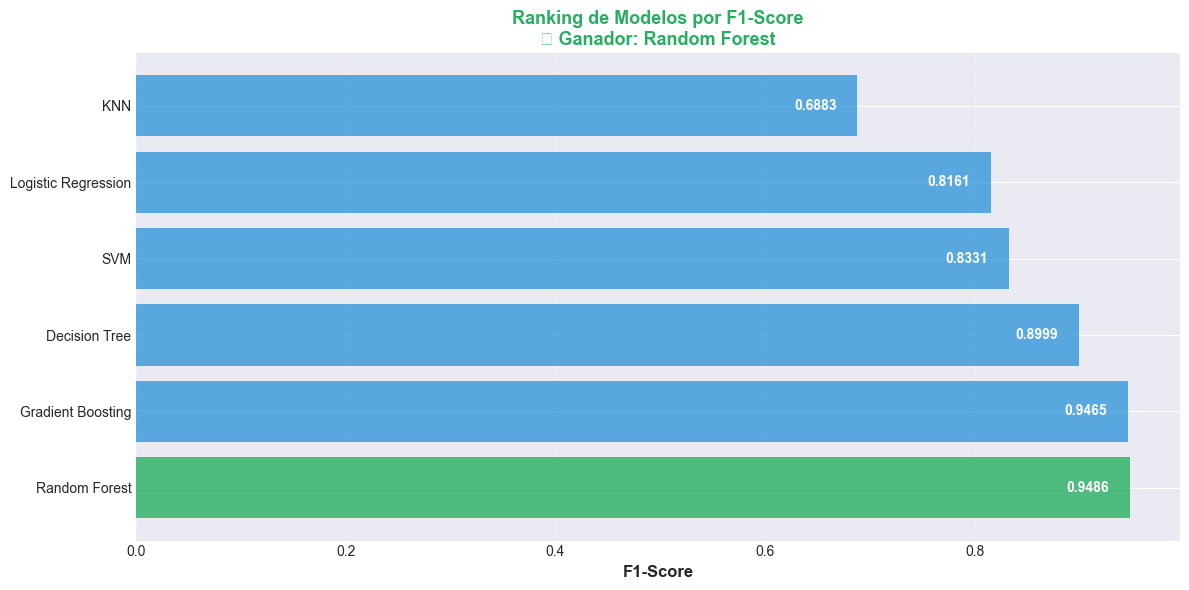

✓ Ranking de modelos guardado


In [14]:
### 9.4 Visualización - Comparación del Mejor Modelo

# Crear visualización de posición del mejor modelo
fig, ax = plt.subplots(figsize=(12, 6))

# Posición en ranking
models_list = results_sorted['Modelo'].tolist()
positions = np.arange(len(models_list))
colors_rank = ['#27AE60' if i == 0 else '#3498DB' for i in range(len(models_list))]

bars = ax.barh(positions, results_sorted['F1-Score'].values, color=colors_rank, alpha=0.8)
ax.set_yticks(positions)
ax.set_yticklabels(models_list)
ax.set_xlabel('F1-Score', fontsize=12, fontweight='bold')
ax.set_title(f'Ranking de Modelos por F1-Score\n🏆 Ganador: {best_model_name}', 
             fontsize=13, fontweight='bold', color='#27AE60')
ax.grid(axis='x', alpha=0.3, linestyle='--')

# Agregar valores en las barras
for i, (bar, value) in enumerate(zip(bars, results_sorted['F1-Score'].values)):
    ax.text(value - 0.02, bar.get_y() + bar.get_height()/2, 
            f'{value:.4f}', ha='right', va='center', fontweight='bold', color='white', fontsize=10)

plt.tight_layout()
plt.savefig(str(artifacts_dir / "model_ranking.png"), dpi=300, bbox_inches='tight')
plt.show()

print("✓ Ranking de modelos guardado")

## 10. Análisis Detallado del Mejor Modelo

Se presentan visualizaciones adicionales para el modelo seleccionado.

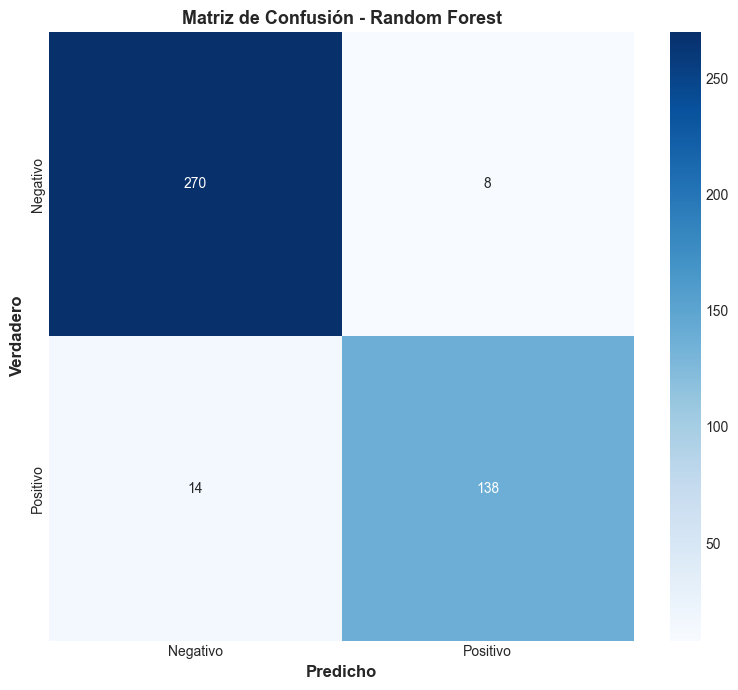

✓ Matriz de confusión guardada

📊 Análisis de la Matriz de Confusión:
   • Verdaderos Positivos (TP): 138
   • Falsos Positivos (FP): 8
   • Verdaderos Negativos (TN): 270
   • Falsos Negativos (FN): 14
   • Sensibilidad (TPR): 0.9079
   • Especificidad (TNR): 0.9712


In [15]:
### 10.1 Matriz de Confusión del Mejor Modelo

# Obtener datos del mejor modelo
best_summary = all_summaries[best_model_name]
cm_best = best_summary['confusion_matrix']

fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', cbar=True, ax=ax,
            xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
ax.set_ylabel('Verdadero', fontsize=12, fontweight='bold')
ax.set_xlabel('Predicho', fontsize=12, fontweight='bold')
ax.set_title(f'Matriz de Confusión - {best_model_name}', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(str(artifacts_dir / "confusion_matrix_best_model.png"), dpi=300, bbox_inches='tight')
plt.show()

print("✓ Matriz de confusión guardada")

# Calcular métricas adicionales desde la matriz
tn, fp, fn, tp = cm_best.ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0

print(f"\n📊 Análisis de la Matriz de Confusión:")
print(f"   • Verdaderos Positivos (TP): {tp}")
print(f"   • Falsos Positivos (FP): {fp}")
print(f"   • Verdaderos Negativos (TN): {tn}")
print(f"   • Falsos Negativos (FN): {fn}")
print(f"   • Sensibilidad (TPR): {sensitivity:.4f}")
print(f"   • Especificidad (TNR): {specificity:.4f}")

In [16]:
### 10.2 Reporte de Clasificación Detallado

print("\n" + "="*80)
print("REPORTE DE CLASIFICACIÓN DETALLADO - MEJOR MODELO")
print("="*80)

# Mostrar reporte
report_dict = best_summary['classification_report']
print(f"\n{classification_report(y_test, best_summary['y_pred'], target_names=['Negativo', 'Positivo'])}")


REPORTE DE CLASIFICACIÓN DETALLADO - MEJOR MODELO

              precision    recall  f1-score   support

    Negativo       0.95      0.97      0.96       278
    Positivo       0.95      0.91      0.93       152

    accuracy                           0.95       430
   macro avg       0.95      0.94      0.94       430
weighted avg       0.95      0.95      0.95       430



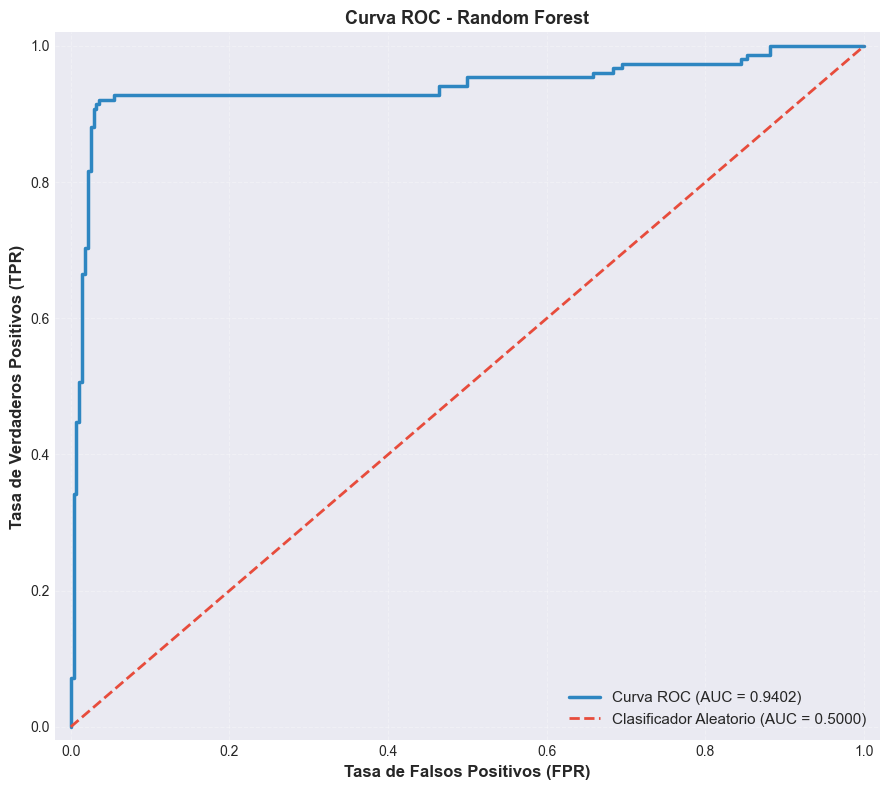

✓ Curva ROC guardada

📊 ROC-AUC Score: 0.9402
   • AUC > 0.9: Excelente
   • AUC > 0.8: Bueno
   • AUC > 0.7: Aceptable
   • AUC < 0.7: Pobre
   ✅ Clasificador excelente


In [17]:
### 10.3 Curva ROC del Mejor Modelo (si es aplicable)

if best_summary['y_proba'] is not None and len(np.unique(y_test)) == 2:
    # Calcular curva ROC
    fpr, tpr, thresholds = roc_curve(y_test, best_summary['y_proba'])
    roc_auc = auc(fpr, tpr)
    
    fig, ax = plt.subplots(figsize=(9, 8))
    
    # Curva ROC
    ax.plot(fpr, tpr, color='#2E86C1', linewidth=2.5, 
            label=f'Curva ROC (AUC = {roc_auc:.4f})')
    
    # Diagonal de referencia (clasificador aleatorio)
    ax.plot([0, 1], [0, 1], color='#E74C3C', linewidth=2, linestyle='--', 
            label='Clasificador Aleatorio (AUC = 0.5000)')
    
    ax.set_xlim([-0.02, 1.02])
    ax.set_ylim([-0.02, 1.02])
    ax.set_xlabel('Tasa de Falsos Positivos (FPR)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Tasa de Verdaderos Positivos (TPR)', fontsize=12, fontweight='bold')
    ax.set_title(f'Curva ROC - {best_model_name}', fontsize=13, fontweight='bold')
    ax.legend(loc='lower right', fontsize=11)
    ax.grid(alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.savefig(str(artifacts_dir / "roc_curve_best_model.png"), dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ Curva ROC guardada")
    print(f"\n📊 ROC-AUC Score: {roc_auc:.4f}")
    print(f"   • AUC > 0.9: Excelente")
    print(f"   • AUC > 0.8: Bueno")
    print(f"   • AUC > 0.7: Aceptable")
    print(f"   • AUC < 0.7: Pobre")
    
    if roc_auc > 0.9:
        print(f"   ✅ Clasificador excelente")
    elif roc_auc > 0.8:
        print(f"   ✅ Clasificador bueno")
    elif roc_auc > 0.7:
        print(f"   ✅ Clasificador aceptable")
    else:
        print(f"   ⚠️ Clasificador pobre")
else:
    print("⚠️ No se puede generar curva ROC (modelos no probabilísticos o multiclase)")

## 11. Guardar el Modelo Entrenado y Artefactos

In [18]:
def save_results_and_model(best_model_name, best_model, results_df):
    """
    Guarda el modelo entrenado y los resultados de evaluación.
    
    Args:
        best_model_name: Nombre del mejor modelo
        best_model: Objeto del mejor modelo entrenado
        results_df: DataFrame con resultados de evaluación
    """
    print("\n" + "="*80)
    print("GUARDANDO ARTEFACTOS DEL MODELO")
    print("="*80)
    
    # Crear directorio de artefactos si no existe
    artifacts_dir.mkdir(parents=True, exist_ok=True)
    
    # 1. Guardar el mejor modelo
    model_path = artifacts_dir / "best_model.joblib"
    joblib.dump(best_model, model_path)
    print(f"\n✅ Modelo guardado exitosamente")
    print(f"   📁 Ubicación: {model_path}")
    print(f"   📝 Modelo: {best_model_name}")
    print(f"   🔧 Tipo: {type(best_model).__name__}")
    
    # 2. Guardar metadata del modelo
    metadata = {
        'model_name': best_model_name,
        'model_type': type(best_model).__name__,
        'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
        'features_count': X_train.shape[1],
        'training_samples': X_train.shape[0],
        'test_samples': X_test.shape[0],
        'metrics': {
            'test_accuracy': float(all_summaries[best_model_name]['test_accuracy']),
            'f1_score': float(all_summaries[best_model_name]['f1_score']),
            'precision': float(all_summaries[best_model_name]['precision']),
            'recall': float(all_summaries[best_model_name]['recall']),
            'roc_auc': float(all_summaries[best_model_name]['roc_auc']) if all_summaries[best_model_name]['roc_auc'] else None,
        }
    }
    
    metadata_path = artifacts_dir / "model_metadata.json"
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=4)
    print(f"\n✅ Metadata del modelo guardada")
    print(f"   📁 Ubicación: {metadata_path}")
    
    # 3. Guardar resultados de evaluación de todos los modelos
    results_path = artifacts_dir / "model_evaluation_results.csv"
    results_df.to_csv(results_path, index=False)
    print(f"\n✅ Resultados de evaluación guardados")
    print(f"   📁 Ubicación: {results_path}")
    print(f"   📊 Modelos evaluados: {len(results_df)}")
    
    # 4. Guardar resumen en formato JSON
    summary_path = artifacts_dir / "training_summary.json"
    training_summary = {
        'best_model': best_model_name,
        'total_models_trained': len(results_df),
        'evaluation_metrics': results_df.to_dict('records'),
        'timestamp': pd.Timestamp.now().isoformat()
    }
    
    with open(summary_path, 'w') as f:
        json.dump(training_summary, f, indent=4)
    print(f"\n✅ Resumen de entrenamiento guardado")
    print(f"   📁 Ubicación: {summary_path}")
    
    print(f"\n{'='*80}")
    print(f"✨ TODOS LOS ARTEFACTOS GUARDADOS EN: {artifacts_dir}")
    print(f"{'='*80}")
    
    return {
        'model_path': str(model_path),
        'metadata_path': str(metadata_path),
        'results_path': str(results_path),
        'summary_path': str(summary_path)
    }

# Ejecutar guardado de artefactos
saved_paths = save_results_and_model(best_model_name, best_model, results_sorted)


GUARDANDO ARTEFACTOS DEL MODELO

✅ Modelo guardado exitosamente
   📁 Ubicación: c:\Users\jsanc\OneDrive\Documentos\U\ML\final-project-ml\mlops_pipeline\artifacts\best_model.joblib
   📝 Modelo: Random Forest
   🔧 Tipo: RandomForestClassifier

✅ Metadata del modelo guardada
   📁 Ubicación: c:\Users\jsanc\OneDrive\Documentos\U\ML\final-project-ml\mlops_pipeline\artifacts\model_metadata.json

✅ Resultados de evaluación guardados
   📁 Ubicación: c:\Users\jsanc\OneDrive\Documentos\U\ML\final-project-ml\mlops_pipeline\artifacts\model_evaluation_results.csv
   📊 Modelos evaluados: 6

✅ Resumen de entrenamiento guardado
   📁 Ubicación: c:\Users\jsanc\OneDrive\Documentos\U\ML\final-project-ml\mlops_pipeline\artifacts\training_summary.json

✨ TODOS LOS ARTEFACTOS GUARDADOS EN: c:\Users\jsanc\OneDrive\Documentos\U\ML\final-project-ml\mlops_pipeline\artifacts


## 12. Resumen Ejecutivo y Conclusiones

In [19]:
print("\n" + "="*80)
print("RESUMEN EJECUTIVO - PASO 3: ENTRENAMIENTO Y EVALUACIÓN DE MODELOS")
print("="*80)

print(f"""

📊 RESULTADOS GLOBALES:
─────────────────────────
  ✓ Modelos entrenados: {len(models)}
  ✓ Modelos evaluados: {len(results_df)}
  ✓ Mejor modelo seleccionado: {best_model_name}

🏆 MEJOR MODELO: {best_model_name}
─────────────────────────────────────
  Rendimiento:
    • Test Accuracy:  {results_sorted.iloc[0]['Test Accuracy']:.4f} ({results_sorted.iloc[0]['Test Accuracy']*100:.2f}%)
    • F1-Score:       {results_sorted.iloc[0]['F1-Score']:.4f}
    • Precision:      {results_sorted.iloc[0]['Precision']:.4f}
    • Recall:         {results_sorted.iloc[0]['Recall']:.4f}
    
  Consistencia:
    • Train Accuracy: {results_sorted.iloc[0]['Train Accuracy']:.4f}
    • Overfitting:    {results_sorted.iloc[0]['Overfitting']:.4f}
    
  Eficiencia:
    • Tiempo de entrenamiento: {results_sorted.iloc[0]['Training Time (s)']:.2f} segundos

📈 COMPARACIÓN CON OTROS MODELOS:
──────────────────────────────────
  Mejor F1-Score:     {results_sorted['F1-Score'].max():.4f} (Ganador: {results_sorted.iloc[0]['Modelo']})
  Peor F1-Score:      {results_sorted['F1-Score'].min():.4f}
  Promedio F1-Score:  {results_sorted['F1-Score'].mean():.4f}
  
  Rango de Accuracy:  {results_sorted['Test Accuracy'].min():.4f} - {results_sorted['Test Accuracy'].max():.4f}

💾 ARTEFACTOS GUARDADOS:
────────────────────────
  ✓ Modelo: {saved_paths['model_path']}
  ✓ Metadata: {saved_paths['metadata_path']}
  ✓ Resultados: {saved_paths['results_path']}
  ✓ Resumen: {saved_paths['summary_path']}
  ✓ Gráficos:
    - model_comparison.png
    - metrics_correlation.png
    - overfitting_time_analysis.png
    - model_ranking.png
    - confusion_matrix_best_model.png
    - roc_curve_best_model.png (si aplica)

✅ PRÓXIMOS PASOS:
──────────────────
  1. Ejecutar model_deploy.py para desplegar el modelo en producción
  2. Utilizar el modelo para hacer predicciones
  3. Monitorear el rendimiento en datos nuevos
  4. Reentrenar periódicamente si se detecta drift

""")

print("="*80)
print("✨ PASO 3 COMPLETADO EXITOSAMENTE")
print("="*80)


RESUMEN EJECUTIVO - PASO 3: ENTRENAMIENTO Y EVALUACIÓN DE MODELOS


📊 RESULTADOS GLOBALES:
─────────────────────────
  ✓ Modelos entrenados: 6
  ✓ Modelos evaluados: 6
  ✓ Mejor modelo seleccionado: Random Forest

🏆 MEJOR MODELO: Random Forest
─────────────────────────────────────
  Rendimiento:
    • Test Accuracy:  0.9488 (94.88%)
    • F1-Score:       0.9486
    • Precision:      0.9488
    • Recall:         0.9488

  Consistencia:
    • Train Accuracy: 0.9878
    • Overfitting:    0.0389

  Eficiencia:
    • Tiempo de entrenamiento: 0.33 segundos

📈 COMPARACIÓN CON OTROS MODELOS:
──────────────────────────────────
  Mejor F1-Score:     0.9486 (Ganador: Random Forest)
  Peor F1-Score:      0.6883
  Promedio F1-Score:  0.8554

  Rango de Accuracy:  0.7070 - 0.9488

💾 ARTEFACTOS GUARDADOS:
────────────────────────
  ✓ Modelo: c:\Users\jsanc\OneDrive\Documentos\U\ML\final-project-ml\mlops_pipeline\artifacts\best_model.joblib
  ✓ Metadata: c:\Users\jsanc\OneDrive\Documentos\U\ML\final-